In [1]:
import netCDF4
import numpy as np
import pandas as pd
import os
import xarray as xr
from fbprophet.utilities import regressor_coefficients
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import multiprocessing
import matplotlib
multiprocessing.set_start_method("fork")

In [2]:
matplotlib.__version__

'3.6.2'

# CERES

In [3]:
ceres_1 = pd.read_parquet("../CERES_2022-11-09_25176/ceres.parquet.gzip")
ceres_2 = pd.read_parquet("../CERES_2022-11-09_25176/ceres1.parquet.gzip")


In [4]:
ceres = pd.concat([ceres_2,ceres_1])

In [5]:
lat_lon_weight = pd.read_csv("zone_weights_lou.txt")

In [6]:
ceres = ceres.query('lat > -66 & lat <66')

In [7]:
weights = []
for index, group in ceres.groupby(level="lat"):
    weight = lat_lon_weight[lat_lon_weight["lat"] ==index]["weight"].iloc[0]
    weights.append(weight)

In [8]:
i=0 
for index, group in ceres.groupby(level="lat"):
    ceres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [9]:
TERMINATOR = True
ceres["albedo"] = ceres["toa_alb_all_mon"]*ceres["weights"]*(1/360.0)
data_agg_ceres = ceres.groupby(level="time").mean()
if TERMINATOR: 
    data_agg_ceres["albedo"]=(360*132/np.sum(weights))*data_agg_ceres["albedo"]
else:
    data_agg_ceres["albedo"]=(360*180)*data_agg_ceres["albedo"]

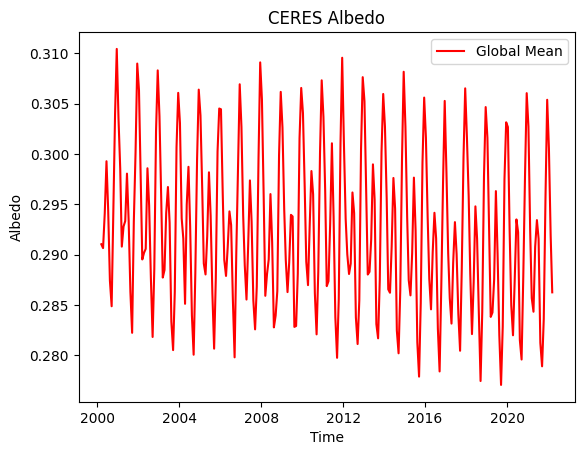

In [10]:
import matplotlib.pyplot as plt
sns.lineplot(data_agg_ceres["albedo"],label="Global Mean",c="red")
plt.ylabel("Albedo")
plt.xlabel("Time")
plt.title("CERES Albedo")
plt.savefig('plots/albedo.png')


### Basline Machine Learning Approach

In [17]:
ceres.reset_index(inplace=True)

In [18]:
to_drop_with_total = [col  for col in ceres.columns if "cld" in col or "lwp" in col or "iwp" in col]
to_drop_no_total = list(filter(lambda x:"total" not in x,to_drop_with_total))
# ceres.drop(to_drop,axis=1,inplace=True)
to_drop_no_total.extend(["weights",])

In [19]:
ceres.drop(to_drop_no_total,axis=1,inplace=True)

In [20]:
import datetime
ceres["month"]=ceres["time"].apply(lambda row: row.month)
ceres["year"]=ceres["time"].apply(lambda row: row.year)


In [21]:
ceres.drop(["albedo","time"],axis=1,inplace=True)

In [22]:
ceres.dropna(inplace=True)

In [23]:
ceres

,lon,lat,toa_alb_all_mon,cldarea_total_mon,cldtau_total_mon,cldtau_lin_total_mon,lwp_total_mon,iwp_total_mon,cldwatrad_total_mon,cldicerad_total_mon,ini_precip_mon,ini_albedo_mon,ini_aod55_mon,aux_snow_mon,month,year
0,0.5,-65.5,0.515776,96.702034,8.803278,18.413727,192.550110,109.389816,11.957646,28.367107,0.588720,0.058539,0.067595,0.000000,3,2000
1,0.5,-65.5,0.500859,89.184845,6.636401,14.176208,154.848648,84.703636,12.129680,26.648327,0.524055,0.081211,0.061990,0.060582,4,2000
2,0.5,-65.5,0.540944,94.382950,3.831486,6.447166,74.194221,70.173920,11.406828,27.335655,0.549051,0.385266,0.019971,68.158051,5,2000
3,0.5,-65.5,0.667543,96.714630,3.304080,5.649391,55.858250,54.954689,11.127936,29.691288,0.390955,0.474759,0.001947,89.646942,6,2000
4,0.5,-65.5,0.729529,90.616035,2.816882,5.654733,48.465176,67.080994,10.033111,26.804031,0.253154,0.628265,0.000582,93.739342,7,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592795,359.5,65.5,0.540336,89.381317,3.487139,6.467061,57.594482,81.958725,12.266736,26.683453,0.974929,0.068863,0.075951,0.000000,11,2021
12592796,359.5,65.5,0.400515,76.908218,2.168095,3.319557,34.413467,46.559574,12.694959,30.657635,0.893233,0.083093,0.109057,0.000000,12,2021
12592797,359.5,65.5,0.631072,90.157585,3.017609,4.435173,41.604218,53.334061,11.896232,26.808008,0.901285,0.064048,0.091496,0.000000,1,2022
12592798,359.5,65.5,0.458924,83.805206,4.019014,10.568074,101.081787,149.167755,13.143770,26.906792,0.670196,0.094881,0.077105,0.000000,2,2022


In [24]:

ceres_samp = ceres.sample(frac=0.05)


In [25]:
import torch
ceres

,lon,lat,toa_alb_all_mon,cldarea_total_mon,cldtau_total_mon,cldtau_lin_total_mon,lwp_total_mon,iwp_total_mon,cldwatrad_total_mon,cldicerad_total_mon,ini_precip_mon,ini_albedo_mon,ini_aod55_mon,aux_snow_mon,month,year
0,0.5,-65.5,0.515776,96.702034,8.803278,18.413727,192.550110,109.389816,11.957646,28.367107,0.588720,0.058539,0.067595,0.000000,3,2000
1,0.5,-65.5,0.500859,89.184845,6.636401,14.176208,154.848648,84.703636,12.129680,26.648327,0.524055,0.081211,0.061990,0.060582,4,2000
2,0.5,-65.5,0.540944,94.382950,3.831486,6.447166,74.194221,70.173920,11.406828,27.335655,0.549051,0.385266,0.019971,68.158051,5,2000
3,0.5,-65.5,0.667543,96.714630,3.304080,5.649391,55.858250,54.954689,11.127936,29.691288,0.390955,0.474759,0.001947,89.646942,6,2000
4,0.5,-65.5,0.729529,90.616035,2.816882,5.654733,48.465176,67.080994,10.033111,26.804031,0.253154,0.628265,0.000582,93.739342,7,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592795,359.5,65.5,0.540336,89.381317,3.487139,6.467061,57.594482,81.958725,12.266736,26.683453,0.974929,0.068863,0.075951,0.000000,11,2021
12592796,359.5,65.5,0.400515,76.908218,2.168095,3.319557,34.413467,46.559574,12.694959,30.657635,0.893233,0.083093,0.109057,0.000000,12,2021
12592797,359.5,65.5,0.631072,90.157585,3.017609,4.435173,41.604218,53.334061,11.896232,26.808008,0.901285,0.064048,0.091496,0.000000,1,2022
12592798,359.5,65.5,0.458924,83.805206,4.019014,10.568074,101.081787,149.167755,13.143770,26.906792,0.670196,0.094881,0.077105,0.000000,2,2022


In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
# Function to train an Extra Trees Classifier and compute SHAP feature importances
# def extra_trees_shap_importance(X, y, n_estimators=500, random_state=42):
    # Split the dataset into training and testing sets
# n_estimators=500
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the Extra Trees Classifier
# clf = ExtraTreesRegressor(n_estimators=n_estimators, 
#                           random_state=42,
#                           max_depth=8,verbose=2)
# #     clf = LinearRegression()
# # clf.fit(X_train, y_train)
# print("clf fit")

# shap_feature_importance,raw_shap_values = extra_trees_shap_importance(X,y) 

In [27]:
X

array([[5.29316569e-06, 1.78531710e-01, 4.31144969e-01, ...,
        0.00000000e+00, 2.87187904e-01, 0.00000000e+00],
       [2.09330466e-03, 6.50116180e-02, 3.83442072e-01, ...,
        0.00000000e+00, 2.74804564e-01, 0.00000000e+00],
       [1.24671892e-02, 3.57588752e-01, 2.59593986e-01, ...,
        0.00000000e+00, 3.08081303e-01, 0.00000000e+00],
       ...,
       [1.54497800e-01, 4.43867064e-01, 1.77166141e-01, ...,
        0.00000000e+00, 3.82901937e-01, 0.00000000e+00],
       [4.84001153e-02, 2.98651781e-01, 1.72566823e-01, ...,
        0.00000000e+00, 2.39991981e-01, 0.00000000e+00],
       [7.87595069e-02, 3.49710241e-01, 1.51485978e-01, ...,
        0.00000000e+00, 1.96134102e-01, 0.00000000e+00]])

In [28]:
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingRegressor

X = ceres.loc[:, ceres.columns!='toa_alb_all_mon']
y = ceres.loc[:, ceres.columns=='toa_alb_all_mon']
X["northern_hemipshere"] = 1.0
X.loc[X['lat'] <= 0,"northern_hemipshere"] = 0.0
X.drop(["lon",
        "lat"],
       axis=1,
       inplace=True)

In [ ]:
X.columns

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
# Define the neural network mode
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Set the device to Apple GPU
# device = torch.device("metal:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
# Hyperparameters
input_size = 14  # Number of input features
hidden_size1 = 256  # Number of hidden units in the first hidden layer
hidden_size2 = 128  # Number of hidden units in the second hidden layer
output_size = 1  # Number of output features (for regression it is 1)
batch_size = 8
learning_rate = 0.001
num_epochs = 4
dropout = 0.0

# # Create sample data

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), 
                                                    y.to_numpy().astype(np.float32), 
                                                    test_size=0.2, 
                                                    random_state=42)
# Create data loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test),
                            torch.tensor(y_test))
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size,
                        shuffle=False)

# # Initialize the model, loss function, and optimizer
model = FeedForwardNN(input_size, 
                      hidden_size1, 
                      hidden_size2, 
                      output_size,
                      dropout).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=1, 
                                      gamma=0.5)

# # # Training loop
for epoch in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as progress_bar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
#             print(data)
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

#             Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the progress bar
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update()

    # Update the learning rate
    scheduler.step()

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/4: 100%|█████| 1259276/1259276 [3:01:32<00:00, 115.61it/s, loss=0.00195]


Epoch [1/4], Loss: 0.0020, Val Loss: 0.0008


Epoch 2/4: 100%|████| 1259276/1259276 [2:56:54<00:00, 118.64it/s, loss=0.000753]


Epoch [2/4], Loss: 0.0008, Val Loss: 0.0012


Epoch 3/4: 100%|██████| 1259276/1259276 [3:00:13<00:00, 116.45it/s, loss=0.0143]


Epoch [3/4], Loss: 0.0143, Val Loss: 0.0014


Epoch 4/4:  13%|▊     | 159308/1259276 [22:49<2:37:35, 116.33it/s, loss=0.00184]


KeyboardInterrupt: 

In [49]:
PATH = "albedo_ffnn_v0.pth"
# torch.save(model, "albedo_ffnn_v0.pth")
model = torch.load(PATH)

In [52]:
steps = np.arange(0,.5,.01)

In [59]:
feature_idx = 10
northern_peturbations = []
for step in steps:
    print(step)
    perturbation_frame = X_test.copy()
    southern_hemisphere = np.where(perturbation_frame[:,13] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,13] == 1)
    np.add.at(perturbation_frame[:,feature_idx], northern_hemisphere, step)
    perturbation_frame = scaler.transform(perturbation_frame).astype(np.float32)
    northern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})


0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49


In [ ]:
feature_idx = 10
southern_peturbations = []
for step in steps:
    print(step)
    perturbation_frame = X_test.copy()
    southern_hemisphere = np.where(perturbation_frame[:,13] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,13] == 1)
    np.add.at(perturbation_frame[:,feature_idx], southern_hemisphere, step)
    perturbation_frame = scaler.transform(perturbation_frame).astype(np.float32)
    southern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})


0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13


<AxesSubplot: xlabel='step', ylabel='prediction'>

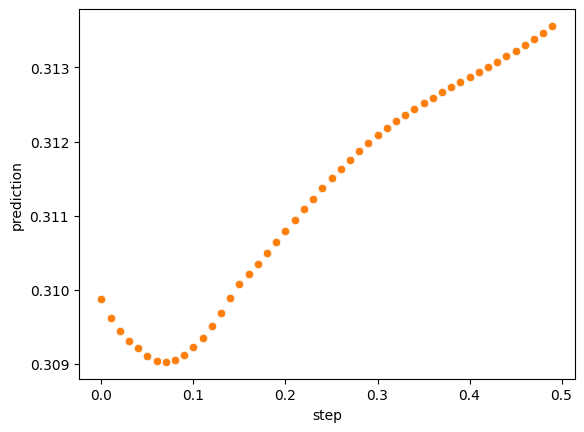

In [65]:
northern_peturb_df = pd.DataFrame(northern_peturbations)
southern_peturb_df = pd.DataFrame(southern_peturbations)

sns.scatterplot(y="prediction",x="step",data=northern_peturb_df)
sns.scatterplot(y="prediction",x="step",data=southern_peturb_df)

In [44]:
predictions = model(torch.tensor(perturbation_frame[0:50000,:]).to(device))
print(predictions.mean())

tensor(0.3060, device='mps:0', grad_fn=<MeanBackward0>)


In [35]:
(predictions.cpu().detach().numpy() - y_test).mean()

0.015498526

In [69]:
perturbation_frame.shape[0]

2518551

In [425]:
scaler.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14'], dtype=object)

In [202]:
from sklearn import metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
regression_results(prediction,y_test)

explained_variance:  0.907
mean_squared_log_error:  0.0005
r2:  0.907
MAE:  0.024
MSE:  0.001
RMSE:  0.032


In [437]:
perturbation_frame = X_test.copy()
# southern_hemisphere = perturbation_frame.loc[X_test['lat'] < 0] 
# northerm_hemisphere = perturbation_frame.loc[X_test['lat'] >= 0] 
# perturbation_frame.loc[southern_hemisphere.index,"ini_aod55_mon"]+=1000

In [438]:
scaler.transform(perturbation_frame)

X does not have valid feature names, but MinMaxScaler was fitted with feature names


array([[ 7.1771641e-04,  5.0734222e-01,  9.0003219e-03, ...,
         0.0000000e+00, -1.6528925e-02, -9.0894630e+01],
       [-9.5824827e-04,  5.0000000e-01,  7.6218466e-03, ...,
         5.9586829e-03, -7.4380167e-02, -9.0892563e+01],
       [ 5.6253432e-04,  5.0477827e-01,  3.0235848e-03, ...,
         0.0000000e+00, -7.4380167e-02, -9.0873970e+01],
       ...,
       [ 8.4186194e-04,  5.0670123e-01,  6.8066265e-03, ...,
         4.3272390e-03, -8.2644626e-02, -9.0888428e+01],
       [-4.6942526e-04,  5.0343806e-01,  5.6289406e-03, ...,
         0.0000000e+00, -1.6528925e-02, -9.0873970e+01],
       [ 1.2026585e-04,  5.0040787e-01,  9.1566108e-03, ...,
         0.0000000e+00, -2.4793385e-02, -9.0892563e+01]], dtype=float32)

In [298]:
# perturbation_frame['ini_aod55_mon'] +=.1
perturbed_prediction = clf.predict(perturbation_frame)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.5s finished


0.3131621092562711 0.3125447219826719


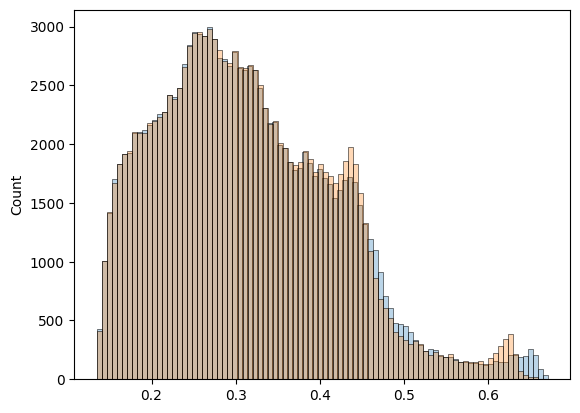

In [299]:
sns.histplot(prediction,alpha=0.3) 
sns.histplot(perturbed_prediction,alpha=0.3) 
print(prediction.mean(),perturbed_prediction.mean())

In [250]:
perturbation_frame['ini_aod55_mon']

10504058    0.201185
1960254     0.207118
4096286     0.231570
7991840     0.196937
6708634     0.370078
              ...   
2971216     0.101958
2796603     1.067570
948357      0.161759
6057923     0.177604
3711501     0.194501
Name: ini_aod55_mon, Length: 125928, dtype: float32

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


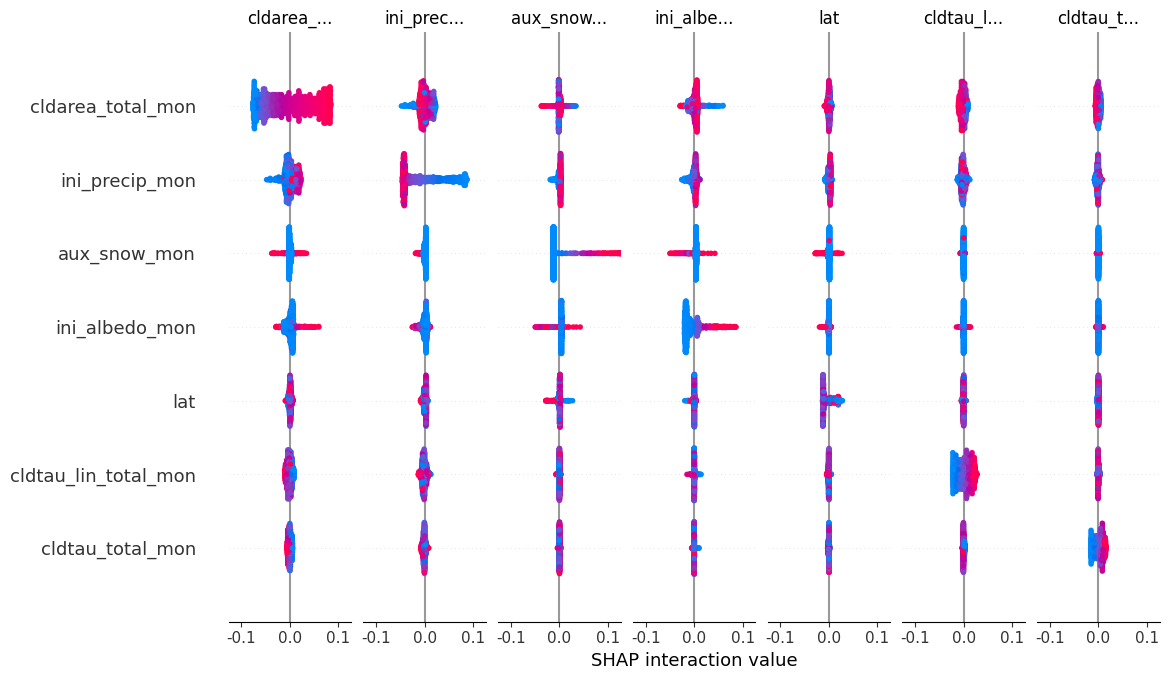

In [203]:
import xgboost
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# Initialize the SHAP explainer with the model
explainer = shap.Explainer(clf)

# Compute SHAP interaction values for a subset of test instances
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:1000, :])

# Plot the SHAP interaction values for a specific instance (e.g., the first instance)
shap_interaction_matrix = pd.DataFrame(shap_interaction_values[0], columns=X.columns, index=X.columns)
shap.summary_plot(shap_interaction_values, X_test.iloc[:1000, :])

In [204]:
shap_values = explainer(X_test)
# shap_values

cld_area_total_mon, ini_albedo_mon, ini_aod55_mon interact with each other and lat, lon, year, month


In [205]:
columns = X_test.columns
print(columns)

Index(['lon', 'lat', 'cldarea_total_mon', 'cldtau_total_mon',
       'cldtau_lin_total_mon', 'lwp_total_mon', 'iwp_total_mon',
       'cldwatrad_total_mon', 'cldicerad_total_mon', 'ini_precip_mon',
       'ini_albedo_mon', 'ini_aod55_mon', 'aux_snow_mon', 'month', 'year'],
      dtype='object')


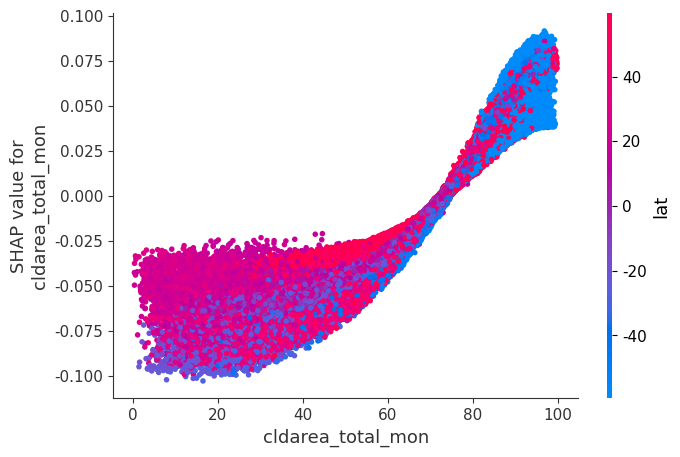

In [206]:
shap.dependence_plot("cldarea_total_mon", 
                     shap_values.values, 
                     X_test,interaction_index=1)

In [207]:
 shap_values[:, interaction_idx].values

array([-0.00147653, -0.00072123, -0.00069437, ..., -0.00014908,
       -0.00013894, -0.0005192 ])

In [208]:
shap_values[:, 1]

.values =
array([ 0.01560841, -0.0017113 , -0.00819872, ..., -0.00901118,
       -0.00108838, -0.00754324])

.base_values =
array([0.31304622, 0.31304622, 0.31304622, ..., 0.31304622, 0.31304622,
       0.31304622])

.data =
array([-62.5, -46.5,  10.5, ..., -31.5,  37.5,  19.5])

In [217]:
# Create a SHAP dependence plot with marginal histogram
index_dict = {}
for i in range(len(columns)):
    index_dict[columns[i]] = i
# feature_idx = 2
# interaction_idx = 10
# shap.plots.scatter(shap_values[:, feature_idx], 
#                    color=shap_values[:, interaction_idx], 
#                     dot_size=0.5,
#                       alpha = 0.5)

# # plt.title("SHAP Dependence Plot")

In [222]:
index_dict
'cld_area_total_mon'

{'lon': 0,
 'lat': 1,
 'cldarea_total_mon': 2,
 'cldtau_total_mon': 3,
 'cldtau_lin_total_mon': 4,
 'lwp_total_mon': 5,
 'iwp_total_mon': 6,
 'cldwatrad_total_mon': 7,
 'cldicerad_total_mon': 8,
 'ini_precip_mon': 9,
 'ini_albedo_mon': 10,
 'ini_aod55_mon': 11,
 'aux_snow_mon': 12,
 'month': 13,
 'year': 14}

In [223]:
interaction_terms = []

variables_1 = ["cldarea_total_mon", "ini_albedo_mon", "ini_aod55_mon"]
variables_2 = ["lat", "lon", "year", "month"]

for i, var1 in enumerate(variables_1):
    for var2 in variables_1[i+1:] + variables_2:
        if var1 != var2:  # To avoid interaction of a variable with itself
            interaction_term = [var1, var2]
            interaction_terms.append(interaction_term)

print(len(interaction_terms))

15


In [235]:
import scipy

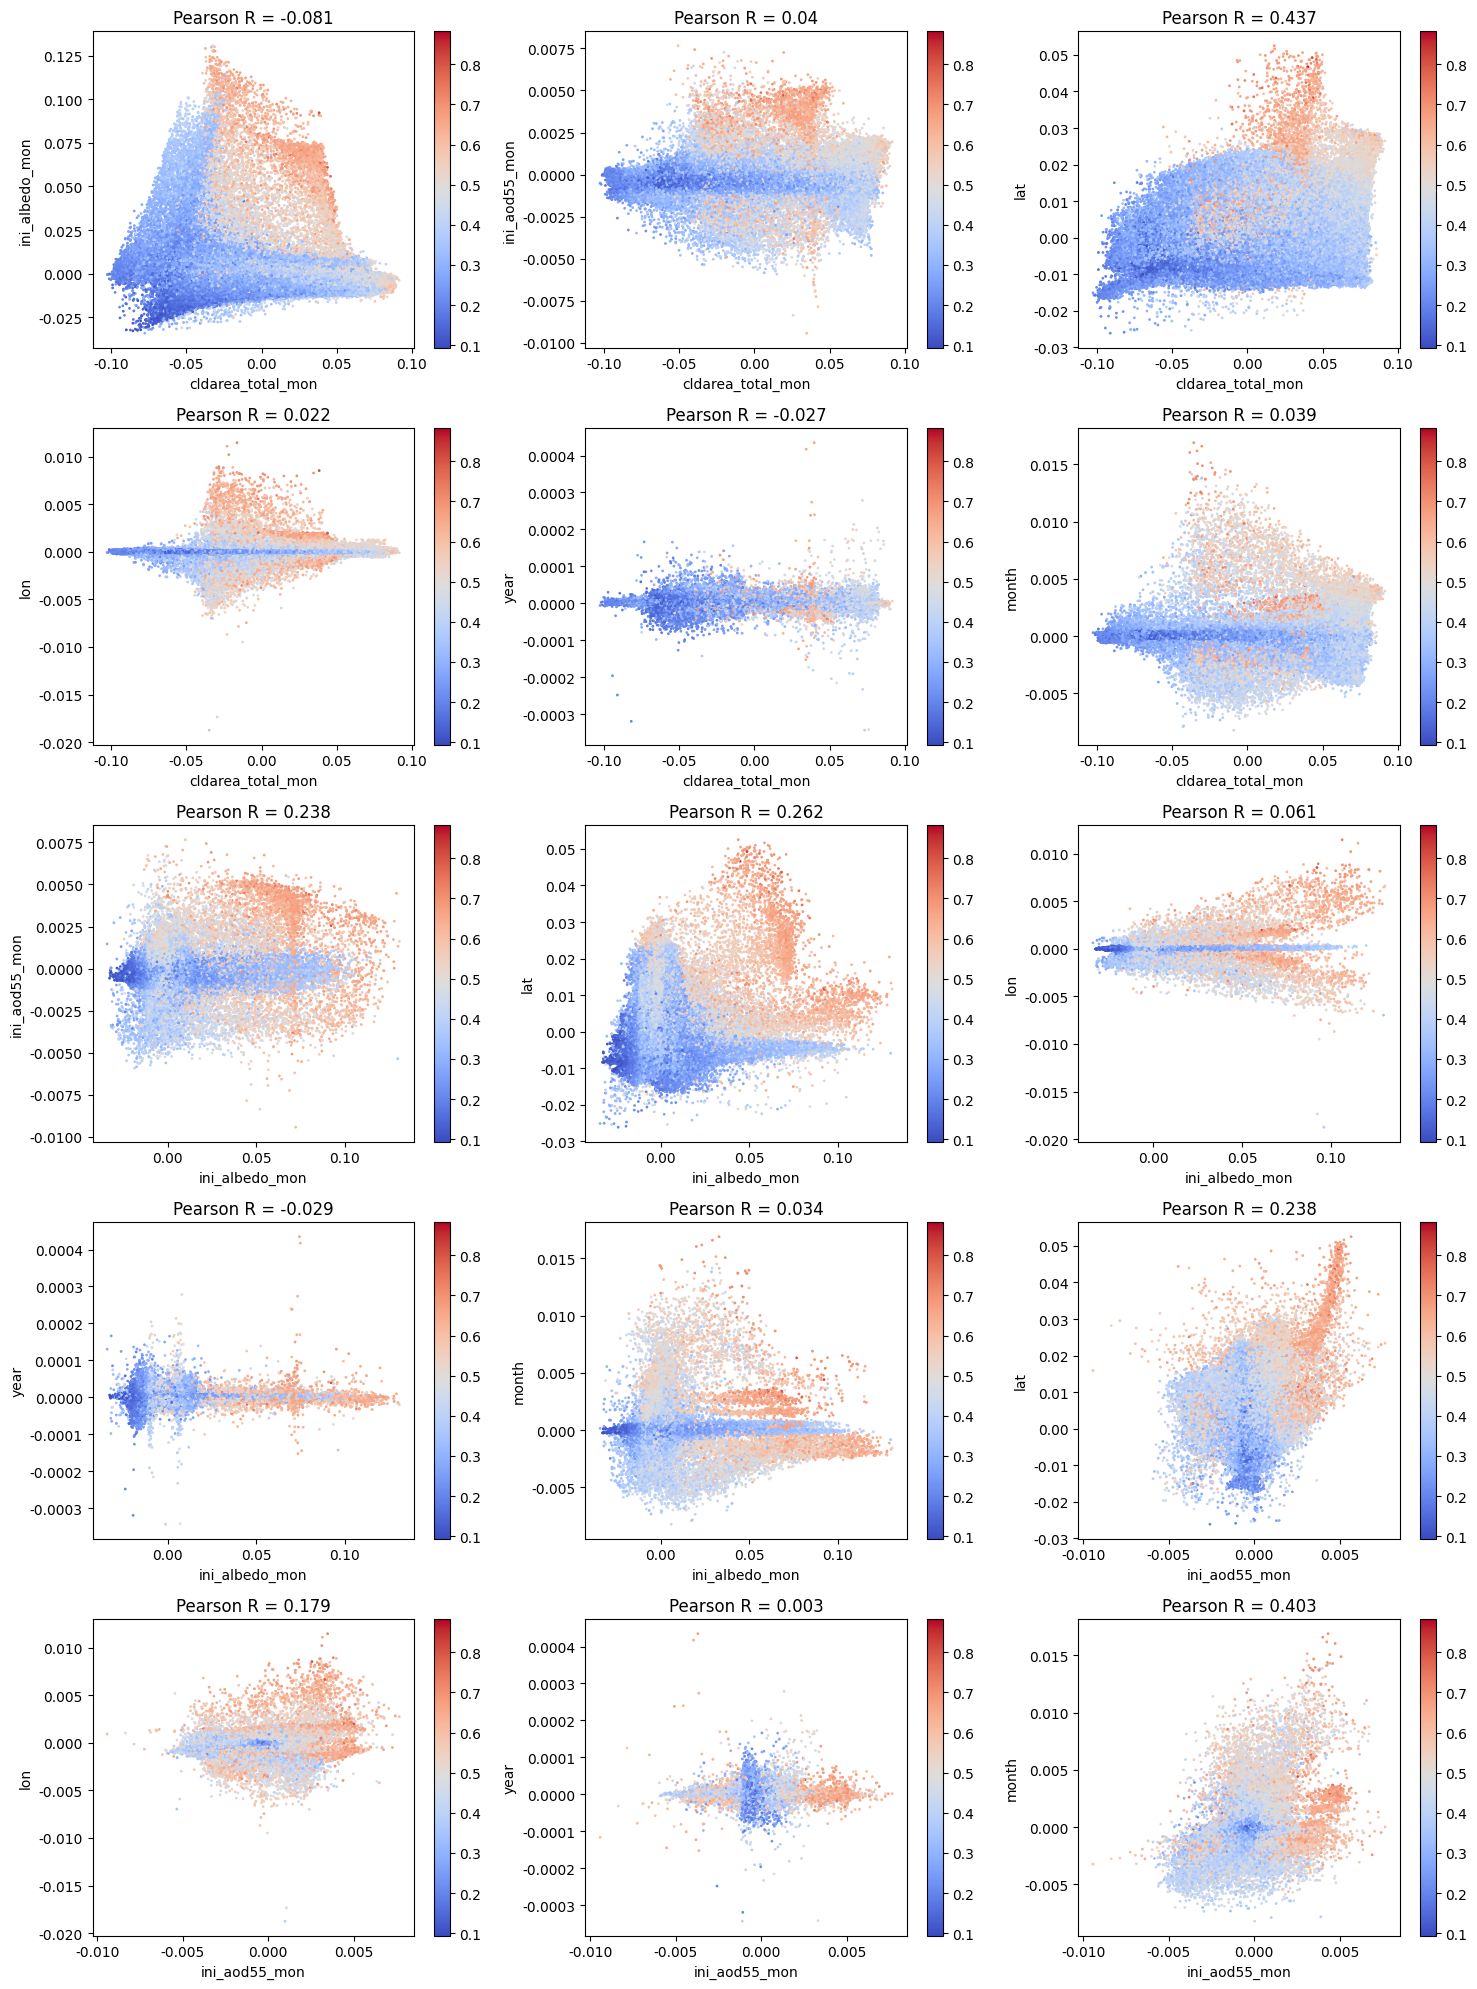

In [241]:
# # Create a SHAP dependence plot with marginal histogram
# print(columns)
# feature_idx = 2
# interaction_idx = 11
# shap.plots.scatter(shap_values[:, feature_idx], 
#                    color=shap_values[:, interaction_idx], 
#                     dot_size=0.5,
#                   alpha = 0.5)

# plt.title("SHAP Dependence Plot")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
def scatter_plot_matrix(data, interaction_terms, index_dict):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
    
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            interaction_term = interaction_terms[i*3 + j]
            x_var, y_var = interaction_term
            x_index, y_index = index_dict[x_var], index_dict[y_var]
            
            im = ax.scatter(data[:, x_index].values, 
                       data[:, y_index].values, 
                       alpha=1,
                       s=1,
                       c = y_test["toa_alb_all_mon"].tolist(),
                        cmap = "coolwarm")
            r, p = scipy.stats.pearsonr(data[:, x_index].values, data[:, y_index].values)
            r=round(r,3)
            ax.set_title(f"Pearson R = {r}")
            plt.colorbar(im, ax=ax)
            ax.set_xlabel(x_var)
            ax.set_ylabel(y_var)
    
    # Remove empty plots if the number of interaction terms is not exactly 15
    for k in range(len(interaction_terms), 15):
        i, j = k // 3, k % 3
        axes[i, j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:

# Create some random data
np.random.seed(42)
data = np.random.rand(100, 8)

# Define the index dictionary


# Call the function with the data, interaction terms, and index dictionary
scatter_plot_matrix(shap_values, interaction_terms, index_dict)
feature_idx = 2
interaction_idx = 11

# fig = plt.scatter(shap_values[:, 10].values,
#                   shap_values[:, 11].values,
#                   c = y_test["toa_alb_all_mon"].tolist(),
#                   cmap = "coolwarm",
#                   s = 1)
# plt.colorbar(fig)
#clouds vs latitude
# cloud vs year
# cloud vs 

Index(['lon', 'lat', 'cldarea_total_mon', 'cldtau_total_mon',
       'cldtau_lin_total_mon', 'lwp_total_mon', 'iwp_total_mon',
       'cldwatrad_total_mon', 'cldicerad_total_mon', 'ini_precip_mon',
       'ini_albedo_mon', 'ini_aod55_mon', 'aux_snow_mon', 'month', 'year'],
      dtype='object')


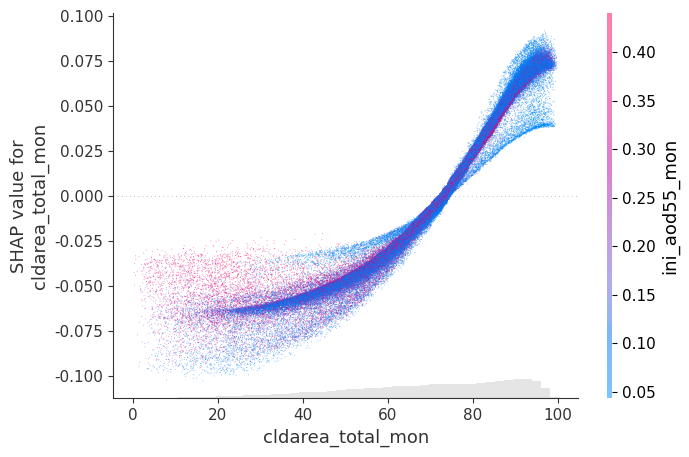

Text(0.5, 1.0, 'SHAP Dependence Plot')

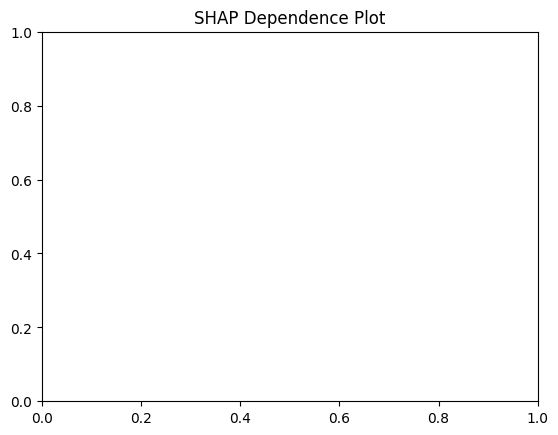

In [242]:
print(columns)
feature_idx = 2
interaction_idx = 11
shap.plots.scatter(shap_values[:, feature_idx], 
                   color=shap_values[:, interaction_idx], 
                    dot_size=0.5,
                  alpha = 0.5)

plt.title("SHAP Dependence Plot")


In [186]:
X_test.reset_index(inplace=True,drop=True)

In [187]:
# Hemespheric Albedo Shap Value comparison 
# Add stepped line plot for aerage shap vs. lat

X_test["cldarea_total_shap"] = shap_values.values[:,2]

In [188]:
north = X_test[X_test["lat"]>0]
south = X_test[X_test["lat"]<0]

In [189]:
south

,lon,lat,cldarea_total_mon,cldtau_total_mon,cldtau_lin_total_mon,lwp_total_mon,iwp_total_mon,cldwatrad_total_mon,cldicerad_total_mon,ini_precip_mon,ini_albedo_mon,ini_aod55_mon,aux_snow_mon,month,year,cldarea_total_shap
0,86.5,-21.5,63.567429,2.517859,8.800539,42.797691,284.714966,13.975579,27.321117,3.888723,0.049654,0.140063,0.0,3,2022,0.056979
1,222.5,-48.5,93.409622,6.042996,9.335619,85.897209,134.279221,15.418830,27.292858,1.083386,0.057232,0.078395,0.0,9,2016,0.019569
2,156.5,-35.5,70.440742,2.932689,9.289352,76.285995,259.695587,13.619672,27.164116,1.607465,0.054293,0.090047,0.0,9,2003,0.049311
7,357.5,-46.5,92.235901,6.365685,13.229534,97.597565,285.188568,13.219815,33.673077,1.032200,0.053970,0.118489,0.0,10,2019,0.073573
8,95.5,-45.5,79.508484,3.996705,12.043437,51.208843,145.620026,11.304153,30.170380,1.095319,0.078286,0.071486,0.0,6,2009,0.030837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125922,346.5,-5.5,39.960320,2.235025,5.665210,65.341972,74.399460,14.006832,28.995863,4.136752,0.047811,0.165147,0.0,4,2013,-0.056496
125923,18.5,-19.5,24.595453,3.670674,12.996809,47.371685,416.300537,8.993268,24.658451,1.660640,0.170867,0.207443,0.0,10,2021,-0.032793
125924,88.5,-48.5,87.517181,5.866915,15.906690,71.216393,257.170776,10.842935,30.344238,1.332577,0.063151,0.105470,0.0,4,2004,-0.050735
125925,296.5,-22.5,75.247200,5.871074,15.527332,101.588318,133.847244,10.766254,20.890244,1.755216,0.106633,0.132280,0.0,6,2019,0.013889


In [190]:
aggregated_data = X_test.groupby("lat").agg("median")

In [191]:
for i in range(len(columns)):
    print(i,columns[i])

0 lon
1 lat
2 cldarea_total_mon
3 cldtau_total_mon
4 cldtau_lin_total_mon
5 lwp_total_mon
6 iwp_total_mon
7 cldwatrad_total_mon
8 cldicerad_total_mon
9 ini_precip_mon
10 ini_albedo_mon
11 ini_aod55_mon
12 aux_snow_mon
13 month
14 year


In [192]:
 shap_values.values[:,2][south.index]

array([ 0.05697921,  0.01956949,  0.04931089, ..., -0.05073506,
        0.01388868,  0.04025952])

invalid value encountered in divide


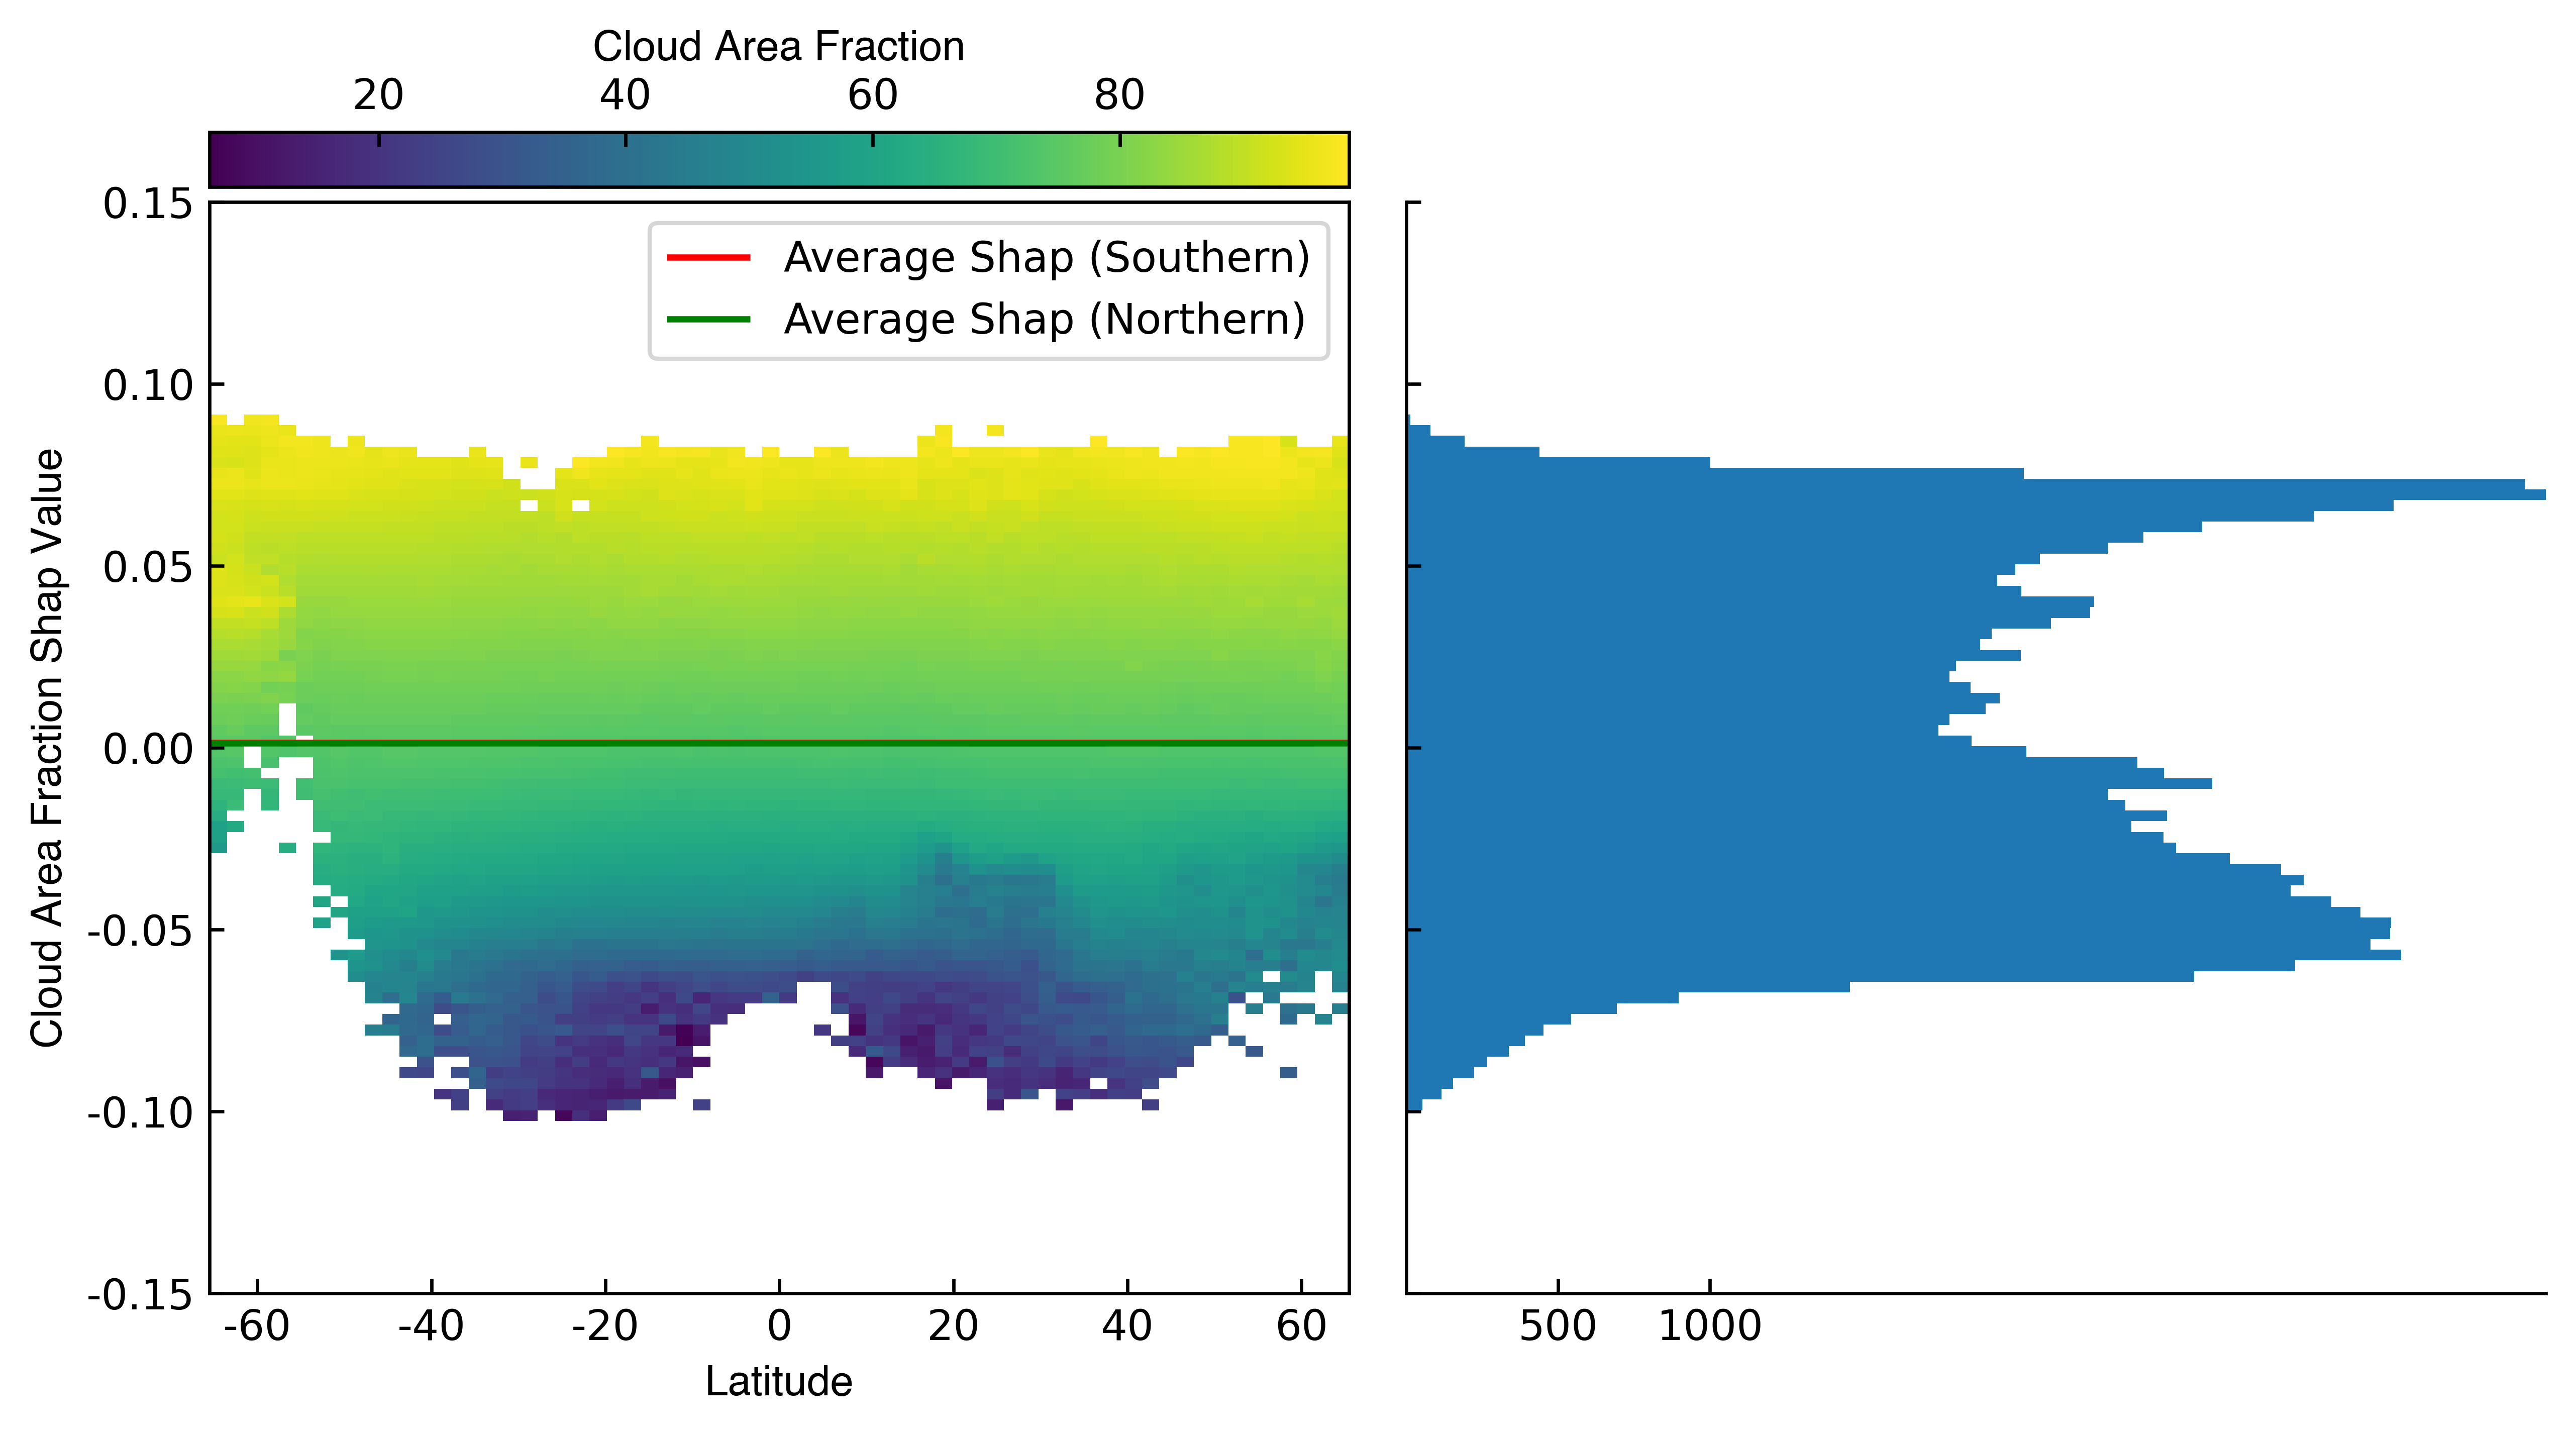

In [244]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "cldarea_total_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 2
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal",cmap="coolwarm")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"Cloud Area Fraction",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"Cloud Area Fraction Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
# ax.hlines( shap_values.values[:,2].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:,2].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,2].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10)


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")

# sns.lineplot(x="lat",
#              y="cldarea_total_shap",
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels() + ax_marginal.get_xticklabels() + ax_marginal.get_yticklabels():
#     lbl.set_fontproperties(helvetica)
# max_height = 0 
# for patch in patches:
#     height = patch.get_width()
#     if height>max_height:
#         max_height = height
# for patch in patches:
#     if  patch.get_width() == max_height:
# #         patch.set_color("blue")
#         patch.set_alpha(1)
#     else:
#         patch.set_alpha(.5)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

invalid value encountered in divide


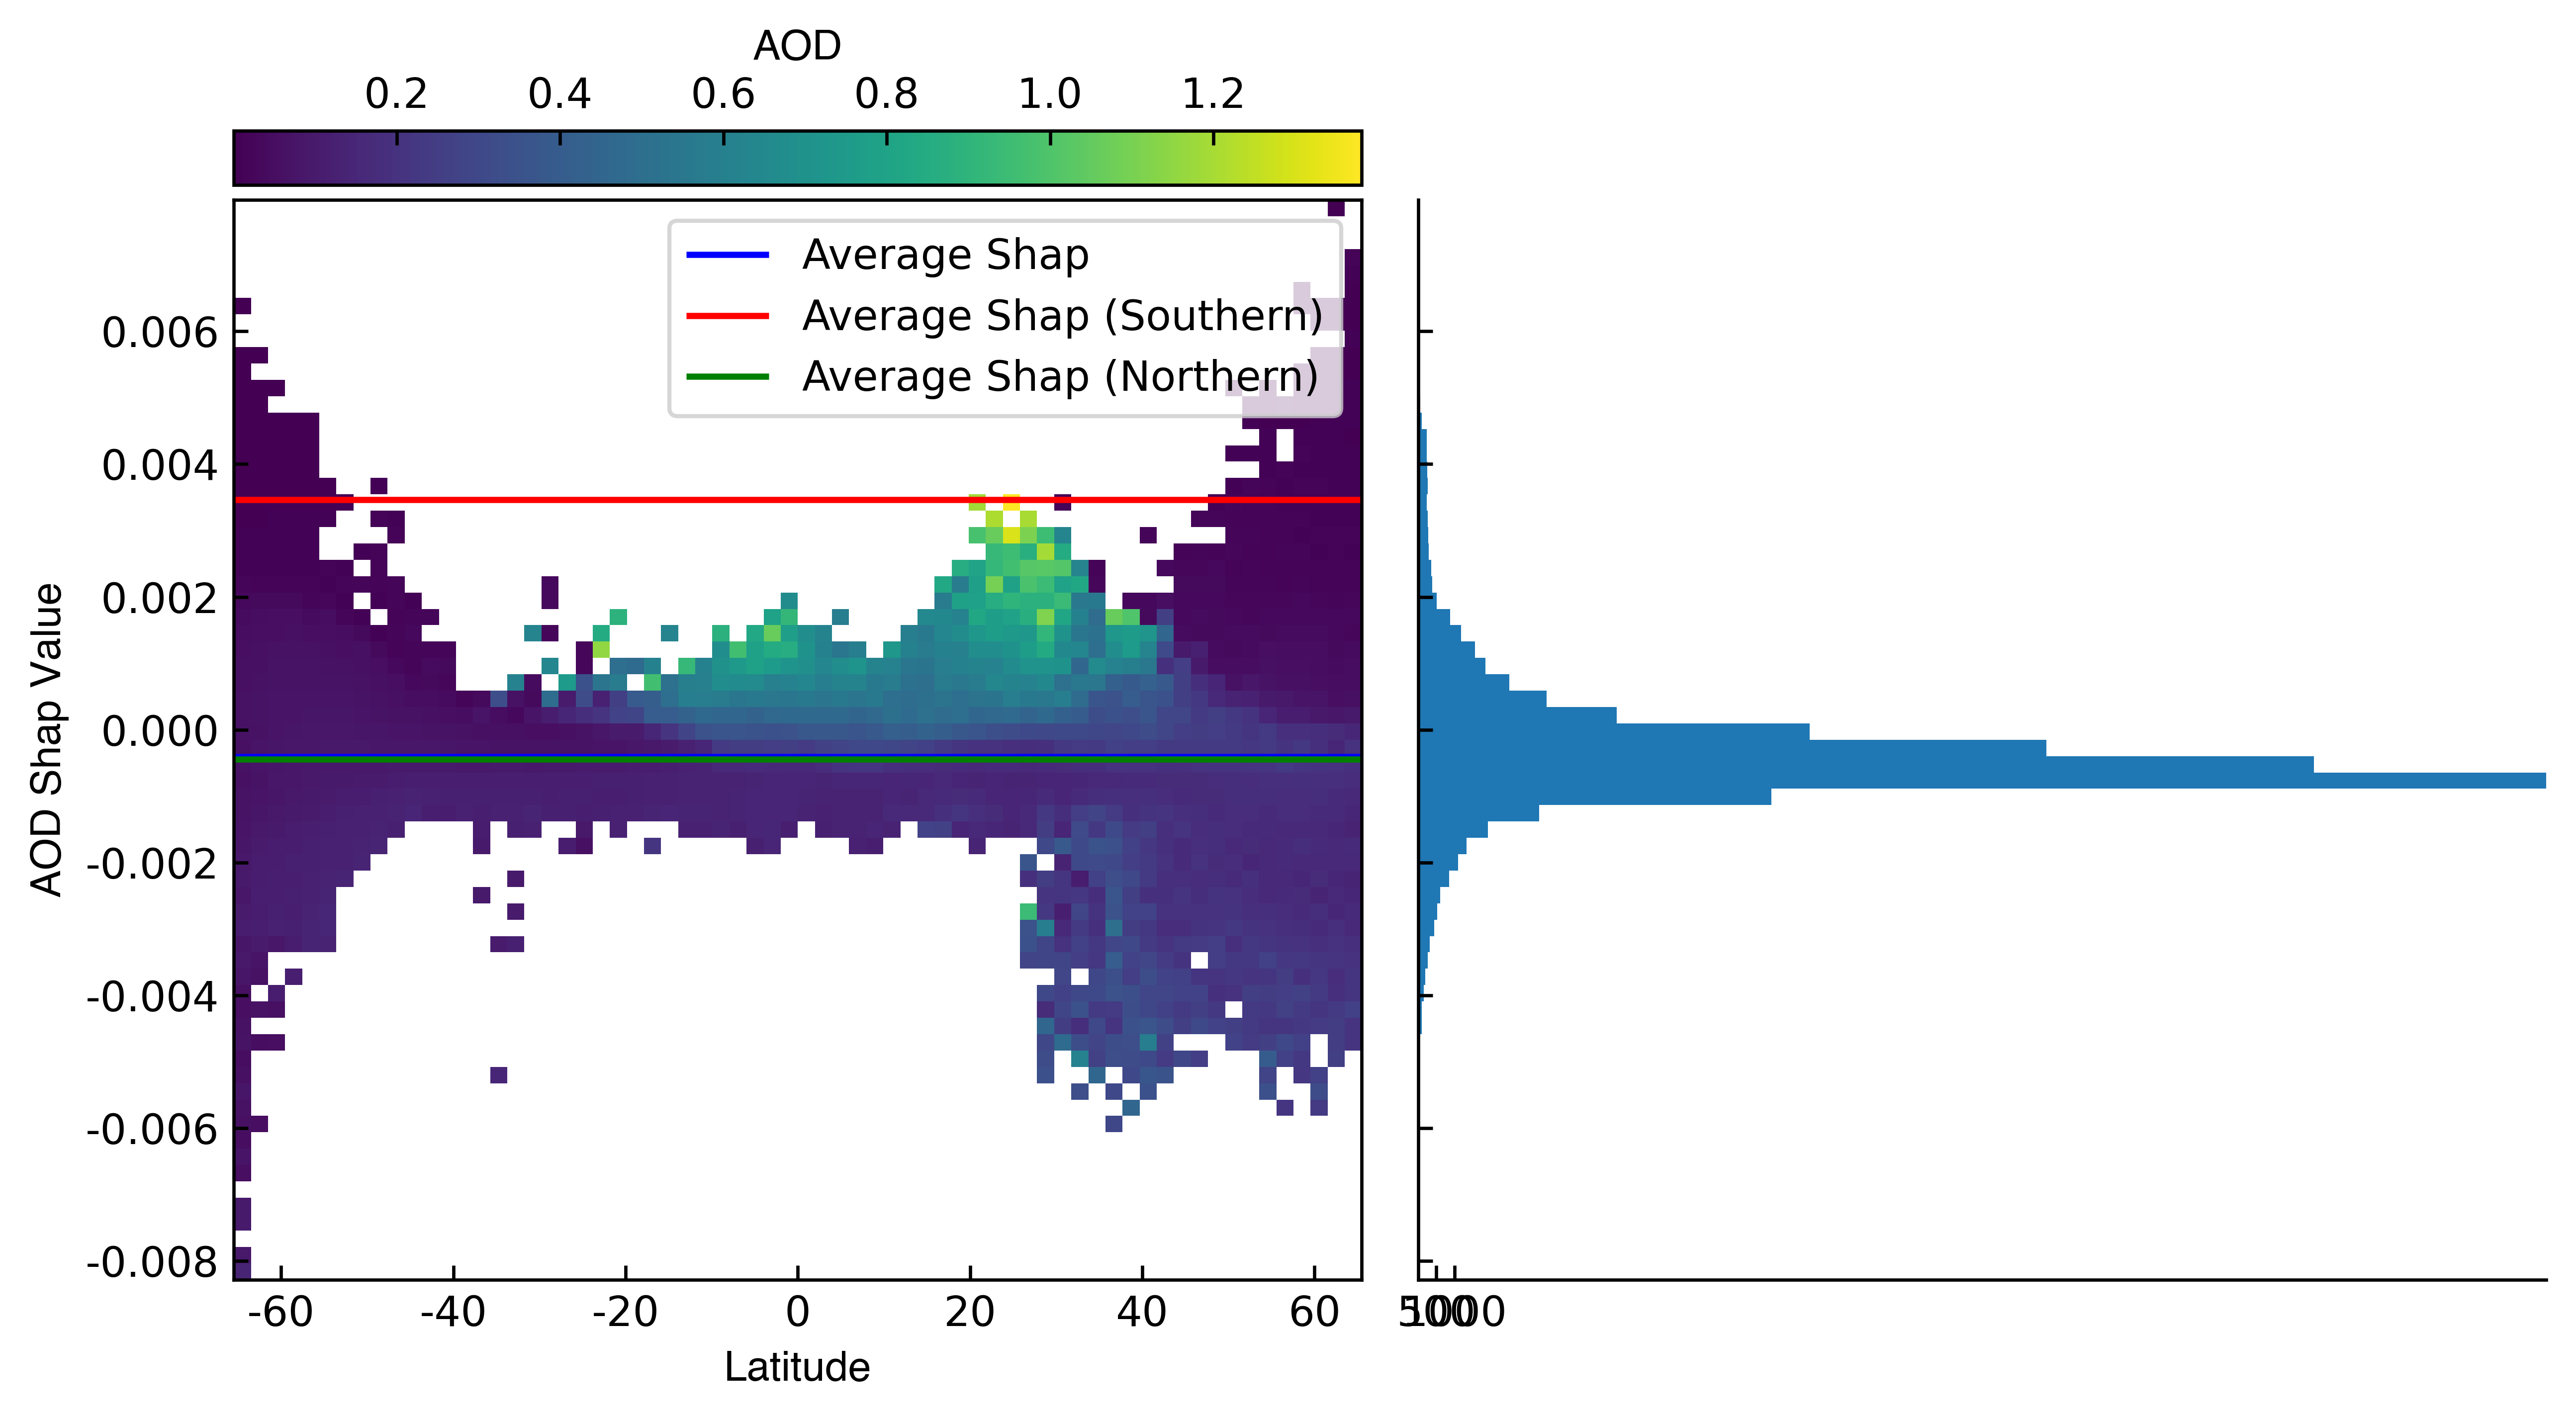

In [149]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "ini_aod55_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 11
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"AOD",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

# ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"AOD Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
ax.hlines( shap_values.values[:,feature_idx].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:feature_idx].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,feature_idx].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10)


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")
# sns.lineplot(x="lat",
#              y=y,
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

invalid value encountered in divide


AttributeError: 'numpy.ndarray' object has no attribute 'median'

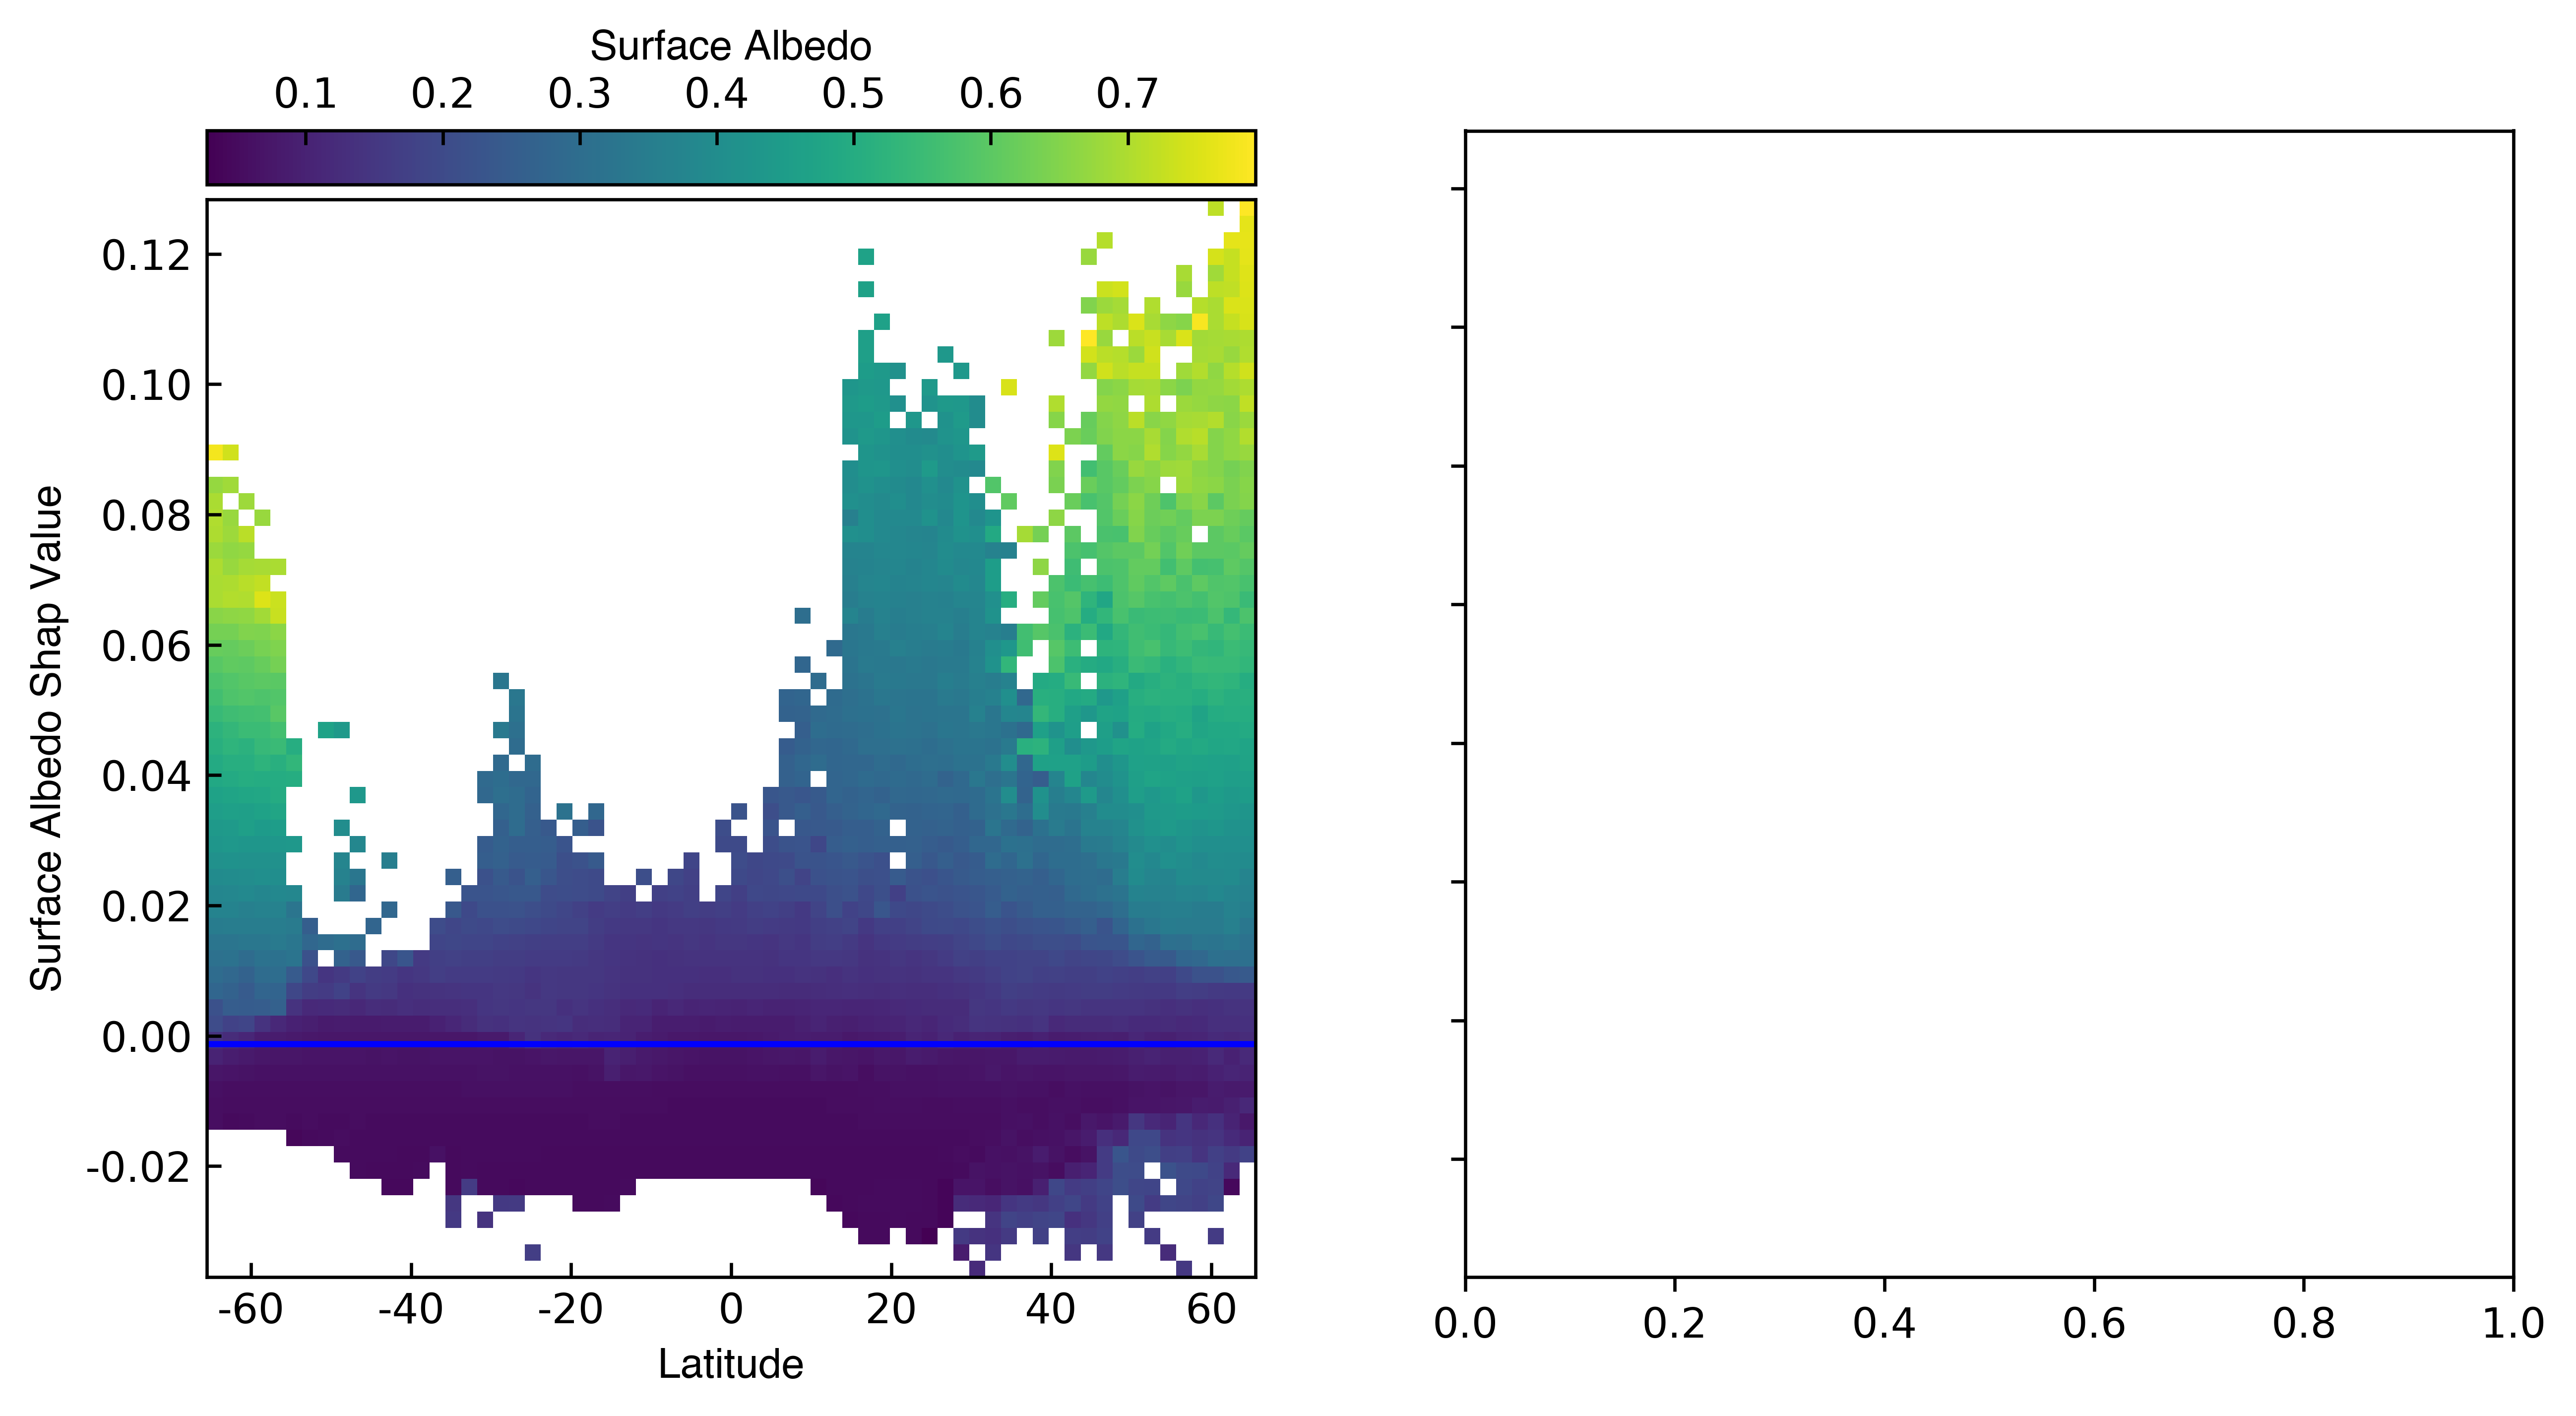

In [151]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "ini_albedo_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 10
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"Surface Albedo",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

# ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"Surface Albedo Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
ax.hlines( shap_values.values[:,feature_idx].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:feature_idx].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,feature_idx].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10,loc="upper left")


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")
# sns.lineplot(x="lat",
#              y=y,
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [147]:
aggregated_data

,lon,cldarea_total_mon,cldtau_total_mon,cldtau_lin_total_mon,lwp_total_mon,iwp_total_mon,cldwatrad_total_mon,cldicerad_total_mon,ini_precip_mon,ini_albedo_mon,ini_aod55_mon,aux_snow_mon,month,year,cldarea_total_shap
lat,,,,,,,,,,,,,,,
-65.5,172.0,91.999557,4.550581,10.009380,108.748604,93.909897,11.122288,28.932741,0.557627,0.470876,0.027626,66.761124,6.0,2011.0,0.039920
-64.5,182.5,93.048615,4.790576,10.023114,106.878944,92.714104,11.327728,28.955160,0.604066,0.365641,0.053423,53.786465,7.0,2011.0,0.047055
-63.5,177.5,93.682526,5.278872,10.609813,108.672180,101.088783,11.462120,29.055941,0.650410,0.124664,0.056377,16.964767,6.0,2011.0,0.058644
-62.5,178.5,94.115891,5.546038,10.940241,108.384094,111.368149,11.624137,29.314728,0.698624,0.070449,0.070876,0.466606,6.0,2010.0,0.064809
-61.5,171.5,93.331734,5.742538,11.232948,106.960838,118.332848,11.750361,29.442554,0.735496,0.066739,0.069091,0.000000,6.0,2011.0,0.065530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61.5,178.5,75.214310,4.013159,9.191295,91.606125,108.939026,11.087126,28.918686,0.841826,0.146581,0.103657,8.768735,7.0,2011.0,0.005543
62.5,180.5,73.943314,3.945789,9.089115,94.905884,106.877548,11.127313,28.834459,0.853147,0.163383,0.104507,13.936518,6.0,2010.0,0.001153
63.5,182.5,72.984116,3.904411,8.807566,94.692345,105.156960,11.171824,28.816025,0.811124,0.181343,0.091077,15.531114,6.0,2011.0,-0.001425


IndexError: index 2 is out of bounds for axis 1 with size 1

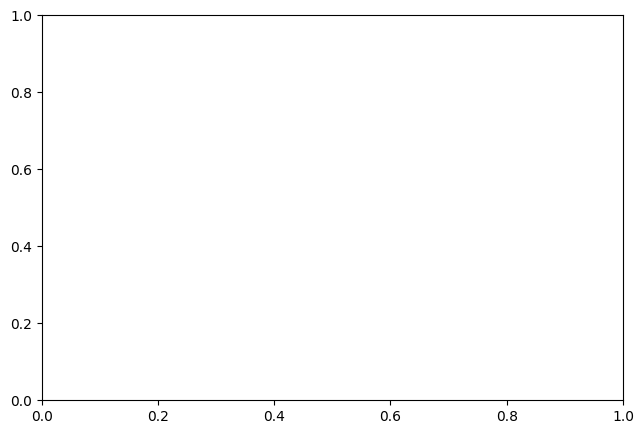

In [69]:
# shap.dependence_plot("cldtau_total_mon", 
#                      shap_values,
#                      X_test,
#                      interaction_index="month")
shap.dependence_plot("cldarea_total_mon", 
                     shap_values, 
                     X_test, 
                     interaction_index="lat")


<AxesSubplot: >

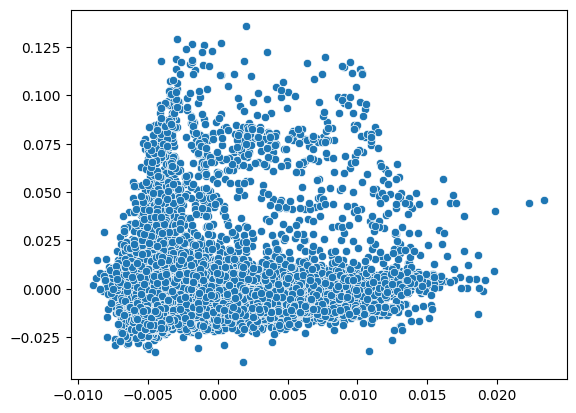

In [60]:
sns.scatterplot(x=shap_values.values[:,5],
                y=shap_values.values[:,10])

Index(['lon', 'lat', 'cldarea_total_mon', 'cldtau_total_mon',
       'cldtau_lin_total_mon', 'lwp_total_mon', 'iwp_total_mon',
       'cldwatrad_total_mon', 'cldicerad_total_mon', 'ini_precip_mon',
       'ini_albedo_mon', 'ini_aod55_mon', 'aux_snow_mon', 'month', 'year'],
      dtype='object')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


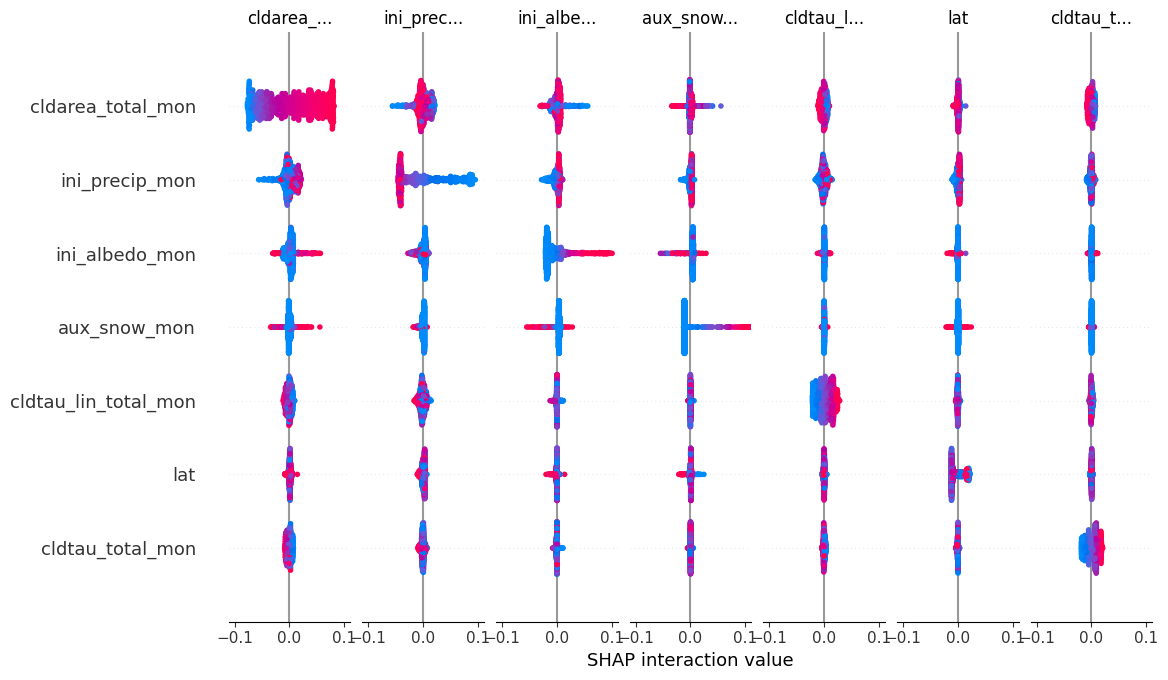

In [35]:
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:1000, :])

shap.summary_plot(shap_interaction_values, X_test.iloc[:1000,:])


In [54]:
# shap.dependence_plot("cldtau_total_mon", 
#                      shap_values, X_test)
shap.dependence_plot("cldtau_total_mon", 
                     shap_values.base_values[0],
                     X_test,
                     interaction_index="month")


TypeError: order must be str, not int

In [52]:
hap.waterfall_plot(explainer.base_values[0], values[0], X[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [ ]:
X_test["performance"] = 100*(X_test["y"]-X_test["predictions"])/X_test["y"]


In [ ]:
X_test.columns

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path

plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))

f, (ax, ax_marginal) = plt.subplots(figsize=(5, 5), ncols=2, dpi=600, sharey=True)



hist = ax.hist2d(
    X_test["lat"],
    X_test["performance"],
    cmap=cmap2.get_mpl_colormap(), 
    weights=X_test["cldarea_total_mon"],
    norm=mpl.colors.LogNorm(),
    bins=66,
#     range=[[limit, upper], [-1, 1]]
)
# ax.plot([limit, upper], [0, 0],  "-", alpha=0.5,  color=line_color)

ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
print(hist[-1])
cbar = plt.colorbar(hist[-1], cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"$R_e$",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
    lbl.set_fontproperties(helvetica)

ax.set_ylim(-150,150)

ax.set_ylabel(
    r"$\cdot\frac{y-\hat{y}}{y}\cdot 100$",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"$lat$",
    fontproperties=helvetica,
)


vals, _, patches = ax_marginal.hist(
    X_test["performance"], 
    bins=66, 
    log=True,
#     range=[-1, 1], 
    orientation="horizontal",
    color=cmap.mpl_colors[-2]
)


In [ ]:
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test["lat"].min(),X_test["lat"].max()],[-150,150]]

counts,_ ,_ = np.histogram2d(X_test["lat"],
                             X_test["performance"],
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test["lat"],
                                    X_test["performance"],
                                       bins=66,
                                       weights=X_test["cldarea_total_mon"])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T,   
               cmap=cmap2.get_mpl_colormap())
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"$A_{cld}$",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
    lbl.set_fontproperties(helvetica)

ax.set_ylim(-150,150)

ax.set_ylabel(
    r"$\cdot\frac{y-\hat{y}}{y}\cdot 100$",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"$lat$",
    fontproperties=helvetica,
)

vals, _, patches = ax_marginal.hist(
    X_test["performance"], 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
    color=cmap.mpl_colors[-2],
    alpha = 0.0)
ax_marginal.tick_params("both", direction="in")
ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels() + ax_marginal.get_xticklabels() + ax_marginal.get_yticklabels():
    lbl.set_fontproperties(helvetica)
max_height = 0 
for patch in patches:
    height = patch.get_width()
    if height>max_height:
        max_height = height
for patch in patches:
    if  patch.get_width() == max_height:
#         patch.set_color("blue")
        patch.set_alpha(1)
    else:
        patch.set_alpha(.5)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [ ]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
X_test["cldarea_total_mon"].max()